# 03 Implementing a TFX Pipeline on Vertex Pipelines on Structured Data

In this notebook, we will create and run a `TFX pipeline` for a classification model. The pipeline will consist of six essential TFX components: `ExampleGen`, `statistics_gen`, `schema_gen`, `example_validator`, `Trainer` and `Pusher`. The pipeline includes ML workflow like importing data, training a model and exporting the trained model into vertex AI pipelines.

The palmer penguins data contains size measurements for `three penguin species` observed on three islands in the Palmer Archipelago, Antarctica.

- For this we are using Penguin dataset, which is a pre existing dataset inside tensorflow
- We will build a classification model which predicts the species of penguins.

`Note:` TFX is a Google-production-scale machine learning toolkit based on TensorFlow. It provides a configuration framework and shared libraries to integrate common components needed to define, launch, and monitor your machine learning system

## 1 - Setup

#### Import libraries

In [1]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx 
print('TFX version: {}'.format(tfx.__version__))
import kfp
print('KFP version: {}'.format(kfp.__version__))

2022-02-18 08:05:12.750189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-18 08:05:12.750229: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.7.1
TFX version: 1.6.1
KFP version: 1.8.11


In [2]:
import os
import pandas as pd
import urllib.request
import tempfile
from ml_metadata.proto import metadata_store_pb2
from tfx.orchestration.portable.mlmd import execution_lib
from tfx.orchestration.experimental.interactive import visualizations
from tfx.orchestration.experimental.interactive import standard_visualizations
from tfx.orchestration.metadata import Metadata
from tfx.types import standard_component_specs

#### Setup GCP Variables

In [3]:
GOOGLE_CLOUD_PROJECT = 'q-gcp-4639-zulily-22-01' # Project id
GOOGLE_CLOUD_REGION = 'us-central1'              # Region
GCS_BUCKET_NAME = 'zulily-tfx-pipeline-testing'  # GCS bucket name
if not (GOOGLE_CLOUD_PROJECT and GOOGLE_CLOUD_REGION and GCS_BUCKET_NAME):
    from absl import logging
    logging.error('Please set all required parameters.')

In [22]:
PIPELINE_NAME = "penguin-data-vertex-pipeline"


# Path to various pipeline artifact.
PIPELINE_ROOT = 'gs://{}/pipeline_root/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# Paths for users' Python module.
MODULE_ROOT = 'gs://{}/pipeline_module/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# Paths for input data.
DATA_ROOT = 'gs://{}/data/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# This is the path where your model will be pushed for serving.
SERVING_MODEL_DIR = 'gs://{}/serving_model/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)


print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))

PIPELINE_ROOT: gs://zulily-tfx-pipeline-testing/pipeline_root/penguin-data-vertex-pipeline


## 2 - Download and prepare Dataset

We will download the dataset `penguins_processed.csv` from tensorflow.org, for use in our TFX pipeline creation. 

There are four independent features and one target feature in this dataset :

Features:

1) `CulmenLength`: The length in mm of the penguin's culmen (bill).
2) `CulmenDepth`: The depth in mm of the penguin's culmen.
3) `FlipperLength`: The length in mm of the penguin's flipper.
4) `BodyMass`: The body mass of the penguin in grams.

Target: 

1) `Species`: An integer value that represents the species of the penguin. 
The Species column is the label we want to train a model to predict. The dataset includes three possible species, which are encoded as 0, 1, and 2. The actual species names `Amelie`, `Gentoo`, `Chinstrap`.


All features were already normalized to have range [0,1]. We will build a classification model which predicts the species of penguins.

In [23]:
!gsutil cp gs://download.tensorflow.org/data/palmer_penguins/penguins_processed.csv {DATA_ROOT}/

Copying gs://download.tensorflow.org/data/palmer_penguins/penguins_processed.csv [Content-Type=application/octet-stream]...
/ [1 files][ 25.0 KiB/ 25.0 KiB]                                                
Operation completed over 1 objects/25.0 KiB.                                     


In [24]:
df = pd.read_csv(os.path.join(DATA_ROOT,"penguins_processed.csv"))
df.head() 

species  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
0        0          0.254545         0.666667           0.152542     0.291667
1        0          0.269091         0.511905           0.237288     0.305556
2        0          0.298182         0.583333           0.389831     0.152778
3        0          0.167273         0.738095           0.355932     0.208333
4        0          0.261818         0.892857           0.305085     0.263889

## 3 - Create a TFX pipeline
TFX pipelines are defined using Python APIs. We will define our pipeline which consists of following six components.

1) `CsvExampleGen`,
2) `statistics_gen`,
3) `schema_gen`,
4) `example_validator`,
5) `Trainer`,
6) `Pusher`

Before actually define the pipeline, we need to write a model code for the Trainer component first.


#### Write model training code
We will create a simple DNN model for classification using TensorFlow Keras API. This model training code will be saved to a separate file.

In this tutorial we will use Generic Trainer of TFX which support Keras-based models. You need to write a Python file containing `run_fn` function, which is the entrypoint for the `Trainer` component.

In [7]:
# Defining the trainer name .py
_trainer_module_file = 'penguin_trainer.py'

In [8]:
%%writefile {_trainer_module_file}

from typing import List
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_transform.tf_metadata import schema_utils
from tfx import v1 as tfx
from tfx_bsl.public import tfxio
from tensorflow_metadata.proto.v0 import schema_pb2

# We don't need to specify _FEATURE_KEYS and _FEATURE_SPEC.
# Those information are being read from the given schema file.

_LABEL_KEY = 'species'

_TRAIN_BATCH_SIZE = 20
_EVAL_BATCH_SIZE = 10

def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int = 200) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema).repeat()


def _build_keras_model(schema: schema_pb2.Schema) -> tf.keras.Model:
  """Creates a DNN Keras model for classifying penguin data.

  Returns:
    A Keras Model.
  """
  # The model below is built with Functional API, please refer to
  # https://www.tensorflow.org/guide/keras/overview for all API options.

  # Uses all features in the schema except the label.
  feature_keys = [f.name for f in schema.feature if f.name != _LABEL_KEY]
  inputs = [keras.layers.Input(shape=(1,), name=f) for f in feature_keys]
  # ++ End of the changed code.

  d = keras.layers.concatenate(inputs)
  for _ in range(2):
    d = keras.layers.Dense(8, activation='relu')(d)
  outputs = keras.layers.Dense(3)(d)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
      optimizer=keras.optimizers.Adam(1e-2),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

  model.summary(print_fn=logging.info)
  return model


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """

  # Reads in schema file passed to the Trainer component.
  schema = tfx.utils.parse_pbtxt_file(fn_args.schema_path, schema_pb2.Schema())
  # ++ End of the changed code.

  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      schema,
      batch_size=_TRAIN_BATCH_SIZE)
  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      schema,
      batch_size=_EVAL_BATCH_SIZE)

  model = _build_keras_model(schema)
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps)

  # The result of the training should be saved in `fn_args.serving_model_dir`
  # directory.
  model.save(fn_args.serving_model_dir, save_format='tf')

Overwriting penguin_trainer.py


Copying the module to the bucket(becauese pipeline will take .py from bucket)
`module root` is a folder inside GCS bucket which contains .py file.

In [9]:
!gsutil cp {_trainer_module_file} {MODULE_ROOT}/ 

Copying file://penguin_trainer.py [Content-Type=text/x-python]...
/ [1 files][  3.3 KiB/  3.3 KiB]                                                
Operation completed over 1 objects/3.3 KiB.                                      


' \nCopying the module to the bucket(becauese pipeline will take .py from bucket)\n`module root` is a folder inside GCS bucket which contains .py file.\n'

## 4 - Write a pipeline definition

Simply put, pipeline is a sequence of components, the output of one component will be the input of next component.

We define a function to create a TFX pipeline. A Pipeline object represents a TFX pipeline which can be run using one of pipeline orchestration systems that TFX supports.

`1)example_gen:` The ExampleGen TFX Pipeline component ingests data into TFX pipelines. It consumes external files/services to generate Examples which will be read by other TFX components. It also provides consistent and configurable partition, and shuffles the dataset for ML best practice.
   - This reads in data files and convert them to TFX internal format for further processing. There are multiple ExampleGens for various formats. In this notebook, we will use CsvExampleGen which takes CSV file input.
   
`2)statistics_gen:`The StatisticsGen TFX pipeline component generates features statistics over both training and serving data, which can be used by other pipeline components. StatisticsGen uses `Beam` to scale to large datasets. 
   - `Consumes`: datasets created by an ExampleGen pipeline component. 
   - `Emits`: Dataset statistics.

`3)schema_gen:` A SchemaGen pipeline component will  generate a schema by inferring types, categories, and ranges from the training data.

`4)example_validator:` Performs anomaly detection based on `statistics` and data `schema` cominng from 
`statistics_gen` and `schema_gen` .
   - example_validator compares  train and test data on statistics_gen and schema_gen basis
   
`5)trainer:` Trains an ML model. Trainer component requires a model definition code from users. You can use TensorFlow APIs to specify how to train a model and save it in a saved_model format.
   - It contains the script to train the model. The script should contain run_fn function where it has model.fit() 
   
`6)pusher:` Copies the trained model outside of the TFX pipeline. Pusher component can be thought of an deployment process of the trained ML model.
   - once the model gets trained inside trainer, it pushes the blessed model to the serving directory where it is ready for serving by using tf_serving etc 
   
  
`Note`:
- `candidate model` is the latest model
- `blessed model`, means out of all iterations done, the last best model(in terms of accuracy or any other metric) is called blessed model.
- Most of tfx components(except trainer and pusher) use `apache beam` for the dataflow job

#### Following is the DAG image from pipeline which is created inside vertex AI
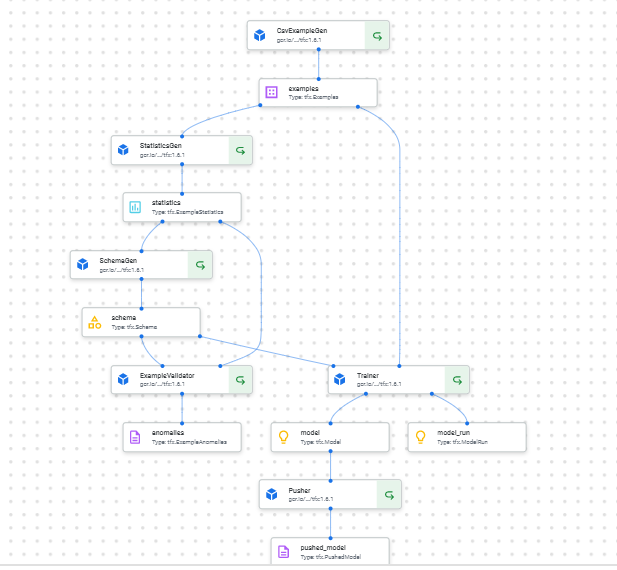

In [12]:
def _create_pipeline(pipeline_name: str, pipeline_root: str, data_root: str,
                     module_file: str, serving_model_dir: str,
                    ) -> tfx.dsl.Pipeline:
    
    """Creates a six component penguin pipeline with TFX."""
    # Brings data into the pipeline.
    example_gen = tfx.components.CsvExampleGen(input_base=data_root)
    
    statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])
    
    #Import the schema.
    schema_gen = tfx.components.SchemaGen(statistics=statistics_gen.outputs['statistics'],
                                          infer_feature_shape=True)

    
    example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
    
    
    # Uses user-provided Python function that trains a model.
    trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=example_gen.outputs['examples'],
      schema=schema_gen.outputs['schema'],  # Pass the imported schema.
      train_args=tfx.proto.TrainArgs(num_steps=100),
      eval_args=tfx.proto.EvalArgs(num_steps=5))

    # Pushes the model to a filesystem destination.
    pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))
    
    

    components = [
      example_gen,
      statistics_gen,
      schema_gen,
      example_validator,
      trainer,
      pusher,
    ]

    return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      components=components)

    """ This will returns a Pipeline object which represents the DAG of TFX components,
  which can be run using one of the pipeline orchestration systems that TFX supports """

## 5 - Run the pipeline on Vertex Pipelines.

In [13]:
# TFX provides multiple orchestrators to run your pipeline.
# In this notebook we will use the Vertex Pipelines together with the Kubeflow V2 dag runner.

PIPELINE_DEFINITION_FILE = PIPELINE_NAME + '_pipeline.json'

""" In this cell we are using KubeflowV2DagRunner to convert the pipeline object(created above) into a pipeline definition file
that can be submitted as a pipeline job to vertex AI """

runner = tfx.orchestration.experimental.KubeflowV2DagRunner(
    config=tfx.orchestration.experimental.KubeflowV2DagRunnerConfig(),
    output_filename=PIPELINE_DEFINITION_FILE)
# Following function will write the pipeline definition to PIPELINE_DEFINITION_FILE.
_ = runner.run(
    _create_pipeline(
        pipeline_name=PIPELINE_NAME,
        pipeline_root=PIPELINE_ROOT,
        data_root=DATA_ROOT,
        module_file=os.path.join(MODULE_ROOT, _trainer_module_file),
        serving_model_dir=SERVING_MODEL_DIR
    ))

In [15]:
# docs_infra: no_execute
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs

aiplatform.init(project=GOOGLE_CLOUD_PROJECT, location=GOOGLE_CLOUD_REGION)

""" We are using the pipeline definition file (json file) created in the above step
to submit a pipeline job inside vrtex AI"""


job = pipeline_jobs.PipelineJob(template_path=PIPELINE_DEFINITION_FILE,
                                display_name=PIPELINE_NAME,
                               enable_caching = True) 

job.run(sync=True)


`enable_caching`: TFX pipeline caching lets your pipeline skip over components that have been executed with the same set of inputs in a previous pipeline run. If caching is enabled, the pipeline attempts to match the signature of each component, the component and set of inputs, to one of this pipeline's previous component executions. If there is a match, the pipeline uses the component outputs from the previous run. If there is not a match, the component is executed

- `enable_caching`  will save time in creating a new pipeline because it uses the successfull artifacts from the previous run(saves memory and time/cost)

##### NOTE:
On your GCP console inside Vertex AI under pipelines you will find a pipeline would be created.

The pipeline runs directly and you can see logs for the progress of the pipeline including ML model training.

